# Исследование тарифных планов компании "Мегалайн" 

_В этом исследовании необходимо проанализировать 5 таблиц с данными о тарифах "Смарт" и "Ультра", предоставленных коммерческим департаментом компании. Данные представлены за 2018 год. Необходимо выяснить какой тариф приносит больше денег._

Основные задачи, которые необходимо решить в исследовании:
 - [изучение данных и составление плана работ](#first_touch);
 - [подготовка данных (предобработка и расчет дополнительных метрик)](#preprocessing);
 - [анализ данных](#analysis);
 - [постановка и проверка гипотез](#hypotesis_and_ab_testing);
 - [вывод](#conclusion).

## Изучение данных и состаление плана работ <a id="first_touch"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

In [2]:
users = pd.read_csv('/datasets/users.csv')

In [3]:
internet = pd.read_csv('/datasets/internet.csv')

In [4]:
calls = pd.read_csv('/datasets/calls.csv')

In [5]:
messages = pd.read_csv('/datasets/messages.csv')

In [6]:
tariffs = pd.read_csv('/datasets/tariffs.csv')

In [7]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [8]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [9]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [10]:
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [11]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [12]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [13]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [14]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [15]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [16]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


В результате первичного изучения данных я обратил внимание на следующие вещи:
- все даты во всех датафреймах записаны в неверных форматах, их необходимо заменить на корректные;
- все данные типа object лучше заменить на строчный тип записи, чтобы избежать появление полных дубликатов;
- в вдатафрейме internet есть столбец, полностью дублирующий значения индексов, его необходимо удалить;
- все значения израсходованных мегабайт и минут необходимо округлить в большую сторону и привести к целочисленному виду, т.к. оператором продаются только целые мегабайты данных;
- нулевые значения в столбцах "использованных минут" и "использованных мегабайтов" необходимо заменить на 1, т.к. любая сессия использования услуги, даже если не было фактического ее использования, подразумевает обращение к инфраструктуре компании, что считается за использование минут или мегабайтов.

Проанализировав детально все столбцы каждого датафрейма я не нашел критических ошибок в данных. Если обнаружатся ошибки буду разбираться с ними дальше.

## Подготовка данных <a id="preprocessing"></a>

_**Датафрейм Users**_

In [17]:
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')

In [18]:
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')

In [19]:
users['city'] = users['city'].str.lower()

In [20]:
users['first_name'] = users['first_name'].str.lower()

In [21]:
users['last_name'] = users['last_name'].str.lower()

In [22]:
users['tariff'] = users['tariff'].str.lower()

In [23]:
users.duplicated().sum()

0

In [24]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaT,краснодар,рафаил,верещагин,2018-05-25,ultra
1,1001,41,NaT,москва,иван,ежов,2018-11-01,smart
2,1002,59,NaT,стерлитамак,евгений,абрамович,2018-06-17,smart
3,1003,23,NaT,москва,белла,белякова,2018-08-17,ultra
4,1004,68,NaT,новокузнецк,татьяна,авдеенко,2018-05-14,ultra


_**Датафрейм Internet**_

In [25]:
del internet['Unnamed: 0']

In [26]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')

In [27]:
internet['mb_used'] = internet['mb_used'].apply(np.ceil).astype('int')

In [28]:
internet.loc[internet['mb_used'] == 0, 'mb_used'] += 1

In [29]:
internet.head()

,id,mb_used,session_date,user_id
0,1000_0,113,2018-11-25,1000
1,1000_1,1053,2018-09-07,1000
2,1000_2,1198,2018-06-25,1000
3,1000_3,551,2018-08-22,1000
4,1000_4,303,2018-09-24,1000


_**Датафрейм Calls**_

In [30]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')

In [31]:
calls['duration'] = calls['duration'].apply(np.ceil).astype('int')

In [32]:
calls.loc[calls['duration'] == 0, 'duration'] += 1

In [33]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,1,1000
1,1000_1,2018-08-17,1,1000
2,1000_2,2018-06-11,3,1000
3,1000_3,2018-09-21,14,1000
4,1000_4,2018-12-15,6,1000


_**Датафрейм Messages**_

In [34]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')

In [35]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


_**Добавление новых метрик в датафрейм Internet**_

In [36]:
internet['month'] = internet['session_date'].dt.month

In [37]:
internet_used = internet.groupby(['user_id','month'])['mb_used'].sum().reset_index()

In [38]:
internet_used.head()

,user_id,month,mb_used
0,1000,5,2257
1,1000,6,23262
2,1000,7,14017
3,1000,8,14072
4,1000,9,14583


_**Добавление новых метрик в датафрейм Calls**_

In [39]:
calls['month'] = calls['call_date'].dt.month

In [40]:
calls_used = (calls
              .groupby(['user_id','month'])
              .agg({"duration":['count','sum']})
              .reset_index()
             )

In [41]:
calls_used.columns = ['user_id','month','calls_count','calls_sum']

In [42]:
calls_used.head()

,user_id,month,calls_count,calls_sum
0,1000,5,22,164
1,1000,6,43,187
2,1000,7,47,346
3,1000,8,52,418
4,1000,9,58,478


_**Добавление новых метрик в датафрейм Messages**_

In [43]:
messages['month'] = messages['message_date'].dt.month

In [44]:
messages_used = messages.groupby(['user_id','month'])['id'].count().reset_index()

In [45]:
messages_used.columns = ['user_id','month','mess_count']

In [46]:
messages_used.head()

,user_id,month,mess_count
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


##  Подсчет промежуточных значений и итоговой выручки

Первым делом я хочу объединить всех активных пользователей (то есть тех кто пользовался любой из услуг: интернет, звонки, смс) в один общий датафрейм.

In [47]:
users_tariff = users.loc[:,['user_id','tariff','city']]

In [48]:
report = (internet_used
            .merge(calls_used, how='outer')
            .merge(messages_used, how='outer')
            .sort_values(['user_id','month'])
            .merge(users_tariff, how='outer')
           ).copy()

In [49]:
report.head()

,user_id,month,mb_used,calls_count,calls_sum,mess_count,tariff,city
0,1000,5.0,2257.0,22.0,164.0,22.0,ultra,краснодар
1,1000,6.0,23262.0,43.0,187.0,60.0,ultra,краснодар
2,1000,7.0,14017.0,47.0,346.0,75.0,ultra,краснодар
3,1000,8.0,14072.0,52.0,418.0,81.0,ultra,краснодар
4,1000,9.0,14583.0,58.0,478.0,57.0,ultra,краснодар


In [50]:
users.query('user_id == 1128')

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
128,1128,51,2018-12-23,волжский,ксения,агаева,2018-12-15,ultra


In [51]:
users.query('user_id == 1371')

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
371,1371,50,2018-12-30,омск,ириней,трофимов,2018-12-25,smart


После объединения датафреймов и узнав какие тарифы были у абонентов, я нашел 2 людей которые не воспользовались никакой из предоставляемых услуг. Изучив их внимательно стало ясно что они были абонентами очень короткое время, и отключили свои сим-карты не совершив никаких действий. Из дальнейшего исследования я их исключаю.

In [52]:
report = report.loc[0:3213]

Все данные об оплатах за услуги по каждому тафиру я записываю как константы, чтобы иметь возможность быстрого доступа к ним.

In [53]:
SMART_FEE = tariffs.query('tariff_name == "smart"').loc[0,'rub_monthly_fee']
SMART_MINS = tariffs.query('tariff_name == "smart"').loc[0,'minutes_included']
SMART_MESS = tariffs.query('tariff_name == "smart"').loc[0,'messages_included']
SMART_GB = tariffs.query('tariff_name == "smart"').loc[0,'mb_per_month_included']
SMART_MIN_ADD = tariffs.query('tariff_name == "smart"').loc[0,'rub_per_minute']
SMART_MESS_ADD = tariffs.query('tariff_name == "smart"').loc[0,'rub_per_message']
SMART_GB_ADD = tariffs.query('tariff_name == "smart"').loc[0,'rub_per_gb']

In [54]:
ULTRA_FEE = tariffs.query('tariff_name == "ultra"').loc[1,'rub_monthly_fee']
ULTRA_MINS = tariffs.query('tariff_name == "ultra"').loc[1,'minutes_included']
ULTRA_MESS = tariffs.query('tariff_name == "ultra"').loc[1,'messages_included']
ULTRA_GB = tariffs.query('tariff_name == "ultra"').loc[1,'mb_per_month_included']
ULTRA_MIN_ADD = tariffs.query('tariff_name == "ultra"').loc[1,'rub_per_minute']
ULTRA_MESS_ADD = tariffs.query('tariff_name == "ultra"').loc[1,'rub_per_message']
ULTRA_GB_ADD = tariffs.query('tariff_name == "ultra"').loc[1,'rub_per_gb']

In [55]:
def tariff_fee(row):
    if row[6] == 'smart':
        return SMART_FEE
    return ULTRA_FEE

In [56]:
def city_category(row):
    if row[7] == 'москва':
        return 'москва'
    return 'другой'

In [57]:
report['tariff_fee'] = report.apply(tariff_fee, axis=1)

In [58]:
report['city_category'] = report.apply(city_category, axis=1)

In [59]:
report.head()

,user_id,month,mb_used,calls_count,calls_sum,mess_count,tariff,city,tariff_fee,city_category
0,1000,5.0,2257.0,22.0,164.0,22.0,ultra,краснодар,1950,другой
1,1000,6.0,23262.0,43.0,187.0,60.0,ultra,краснодар,1950,другой
2,1000,7.0,14017.0,47.0,346.0,75.0,ultra,краснодар,1950,другой
3,1000,8.0,14072.0,52.0,418.0,81.0,ultra,краснодар,1950,другой
4,1000,9.0,14583.0,58.0,478.0,57.0,ultra,краснодар,1950,другой


In [60]:
report['mb_used'] = report['mb_used'].fillna(0)
report['calls_sum'] = report['calls_sum'].fillna(0)
report['mess_count'] = report['mess_count'].fillna(0)

Все пропуски с толбцах 'mb_used', 'calls_sum', 'mess_count' появились при слиянии датафреймов из-за отсутствия в них значений. Если значение отсутствует, значит абонент не пользовался данной услугой. Логично заменить их на 0.

Далее для подсчета итоговой выручки я буду придерживаться следующей логики: услуги сверх тарифа продаются целыми частями. Это значит что если абонент совершил звонков на дополнительных 30 секунд, ему зачтется целая минута. Так же и с гигабайтами интернета, если абонент потратил дополнительных 500 Мб трафика, это будет считаться как целый потраченый Гигабайт. Ниже в отдельных столбцах я посчитаю размер потраченных доп услуг и их стоимость.

In [61]:
smart = report.query('tariff == "smart"').copy()

In [62]:
smart.head()

,user_id,month,mb_used,calls_count,calls_sum,mess_count,tariff,city,tariff_fee,city_category
8,1001,11.0,18460.0,59.0,444.0,0.0,smart,москва,550,москва
9,1001,12.0,14059.0,63.0,430.0,0.0,smart,москва,550,москва
10,1002,6.0,10878.0,15.0,118.0,4.0,smart,стерлитамак,550,другой
11,1002,7.0,17615.0,26.0,219.0,11.0,smart,стерлитамак,550,другой
12,1002,8.0,20357.0,42.0,294.0,13.0,smart,стерлитамак,550,другой


In [63]:
smart['add_int_gb'] = (smart['mb_used'] - SMART_GB * 1024) / 1024

In [64]:
smart['add_int_gb'] = smart['add_int_gb'].apply(np.ceil)

In [65]:
smart.loc[smart['add_int_gb'] < 0,'add_int_gb'] = 0

In [66]:
smart['add_int_cost'] = smart['add_int_gb'] * SMART_GB_ADD

In [67]:
smart['add_calls_min'] = smart['calls_sum'] - SMART_MINS

In [68]:
smart.loc[smart['add_calls_min'] < 0,'add_calls_min'] = 0

In [69]:
smart['add_calls_cost'] = smart['add_calls_min'] * SMART_MIN_ADD

In [70]:
smart['add_mess_count'] = smart['mess_count'] - SMART_MESS

In [71]:
smart.loc[smart['add_mess_count'] < 0,'add_mess_count'] = 0

In [72]:
smart['add_mess_cost'] = smart['add_mess_count'] * SMART_MESS_ADD

In [73]:
smart['revenue'] = report['tariff_fee'] + smart['add_int_cost'] + smart['add_calls_cost'] + smart['add_mess_cost']

In [74]:
smart.head()

,user_id,month,mb_used,calls_count,calls_sum,mess_count,tariff,city,tariff_fee,city_category,add_int_gb,add_int_cost,add_calls_min,add_calls_cost,add_mess_count,add_mess_cost,revenue
8,1001,11.0,18460.0,59.0,444.0,0.0,smart,москва,550,москва,0.0,0.0,0.0,0.0,0.0,0.0,550.0
9,1001,12.0,14059.0,63.0,430.0,0.0,smart,москва,550,москва,0.0,0.0,0.0,0.0,0.0,0.0,550.0
10,1002,6.0,10878.0,15.0,118.0,4.0,smart,стерлитамак,550,другой,0.0,0.0,0.0,0.0,0.0,0.0,550.0
11,1002,7.0,17615.0,26.0,219.0,11.0,smart,стерлитамак,550,другой,0.0,0.0,0.0,0.0,0.0,0.0,550.0
12,1002,8.0,20357.0,42.0,294.0,13.0,smart,стерлитамак,550,другой,0.0,0.0,0.0,0.0,0.0,0.0,550.0


In [75]:
ultra = report.query('tariff == "ultra"').copy()

In [76]:
ultra.head()

,user_id,month,mb_used,calls_count,calls_sum,mess_count,tariff,city,tariff_fee,city_category
0,1000,5.0,2257.0,22.0,164.0,22.0,ultra,краснодар,1950,другой
1,1000,6.0,23262.0,43.0,187.0,60.0,ultra,краснодар,1950,другой
2,1000,7.0,14017.0,47.0,346.0,75.0,ultra,краснодар,1950,другой
3,1000,8.0,14072.0,52.0,418.0,81.0,ultra,краснодар,1950,другой
4,1000,9.0,14583.0,58.0,478.0,57.0,ultra,краснодар,1950,другой


In [77]:
ultra['add_int_gb'] = (ultra['mb_used'] - ULTRA_GB * 1024) / 1024

In [78]:
ultra['add_int_gb'] = ultra['add_int_gb'].apply(np.ceil)

In [79]:
ultra.loc[ultra['add_int_gb'] < 0,'add_int_gb'] = 0

In [80]:
ultra['add_int_cost'] = ultra['add_int_gb'] * ULTRA_GB_ADD

In [81]:
ultra['add_calls_min'] = ultra['calls_sum'] - ULTRA_MINS

In [82]:
ultra.loc[ultra['add_calls_min'] < 0,'add_calls_min'] = 0

In [83]:
ultra['add_calls_cost'] = ultra['add_calls_min'] * ULTRA_MIN_ADD

In [84]:
ultra['add_mess_count'] = ultra['mess_count'] - ULTRA_MESS

In [85]:
ultra.loc[ultra['add_mess_count'] < 0,'add_mess_count'] = 0

In [86]:
ultra['add_mess_cost'] = ultra['add_mess_count'] * ULTRA_MESS_ADD

In [87]:
ultra['revenue'] = ultra['tariff_fee'] + ultra['add_int_cost'] + ultra['add_calls_cost'] + ultra['add_mess_cost']

In [88]:
ultra.head()

,user_id,month,mb_used,calls_count,calls_sum,mess_count,tariff,city,tariff_fee,city_category,add_int_gb,add_int_cost,add_calls_min,add_calls_cost,add_mess_count,add_mess_cost,revenue
0,1000,5.0,2257.0,22.0,164.0,22.0,ultra,краснодар,1950,другой,0.0,0.0,0.0,0.0,0.0,0.0,1950.0
1,1000,6.0,23262.0,43.0,187.0,60.0,ultra,краснодар,1950,другой,0.0,0.0,0.0,0.0,0.0,0.0,1950.0
2,1000,7.0,14017.0,47.0,346.0,75.0,ultra,краснодар,1950,другой,0.0,0.0,0.0,0.0,0.0,0.0,1950.0
3,1000,8.0,14072.0,52.0,418.0,81.0,ultra,краснодар,1950,другой,0.0,0.0,0.0,0.0,0.0,0.0,1950.0
4,1000,9.0,14583.0,58.0,478.0,57.0,ultra,краснодар,1950,другой,0.0,0.0,0.0,0.0,0.0,0.0,1950.0



Для обоих тарифов по каждому пользователю я подсчитал итоговую выручку за каждый месяц. Далее можно детально проанализировать каждый тариф отдельно.

## Анализ тарифных планов <a id="analysis"></a>

### Тариф "Смарт"

In [89]:
smart.head()

,user_id,month,mb_used,calls_count,calls_sum,mess_count,tariff,city,tariff_fee,city_category,add_int_gb,add_int_cost,add_calls_min,add_calls_cost,add_mess_count,add_mess_cost,revenue
8,1001,11.0,18460.0,59.0,444.0,0.0,smart,москва,550,москва,0.0,0.0,0.0,0.0,0.0,0.0,550.0
9,1001,12.0,14059.0,63.0,430.0,0.0,smart,москва,550,москва,0.0,0.0,0.0,0.0,0.0,0.0,550.0
10,1002,6.0,10878.0,15.0,118.0,4.0,smart,стерлитамак,550,другой,0.0,0.0,0.0,0.0,0.0,0.0,550.0
11,1002,7.0,17615.0,26.0,219.0,11.0,smart,стерлитамак,550,другой,0.0,0.0,0.0,0.0,0.0,0.0,550.0
12,1002,8.0,20357.0,42.0,294.0,13.0,smart,стерлитамак,550,другой,0.0,0.0,0.0,0.0,0.0,0.0,550.0


In [90]:
smart_general = (smart
               .pivot_table(index='month', values=('mb_used','calls_sum','mess_count'), aggfunc=('mean'))
               .reset_index()
             )

In [91]:
smart_general

,month,calls_sum,mb_used,mess_count
0,1.0,209.647059,8528.588235,18.235294
1,2.0,306.310345,11617.344828,24.086207
2,3.0,400.532468,15131.207792,31.857143
3,4.0,377.000000,13486.080357,30.741071
4,5.0,398.404255,15832.751773,33.773050
5,6.0,406.701220,15822.445122,33.402439
6,7.0,419.288557,15771.398010,33.751244
7,8.0,433.191489,16640.212766,33.638298
8,9.0,440.080769,16332.615385,33.638462
9,10.0,438.295918,16786.853741,33.765306


#### Исследование параметра 'mb_used'

In [92]:
smart['mb_used'].mean()

16237.184387617766

In [93]:
smart_var_int = np.var(smart['mb_used'], ddof=1)

In [94]:
smart_var_int

34571991.09480102

In [95]:
smart_st_d_int = np.std(smart['mb_used'], ddof=1)

In [96]:
smart_st_d_int

5879.795157554472

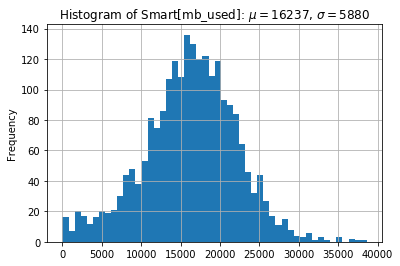

In [97]:
smart['mb_used'].plot(
    kind='hist', bins=50, grid=True, title='Histogram of Smart[mb_used]: $\mu=16237$, $\sigma=5880$')
plt.show()

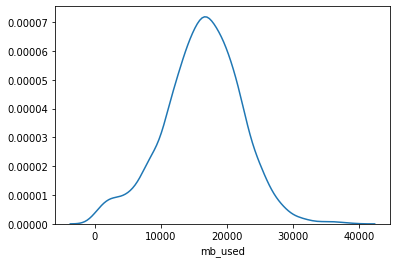

In [98]:
sns.distplot(smart['mb_used'], hist=False)
plt.show()

#### Описание распределения

Распределение непрерывной величины - количества использованных мегабайтов трафика, очень близко к нормальному распределению. Но стоит заметить что оно несеммитрично и имеет слабовыраженную скошенность влево.

#### Исследование параметра 'calls_sum'

In [99]:
smart['calls_sum'].mean()

429.45087483176314

In [100]:
smart_var_calls = np.var(smart['calls_sum'], ddof=1)

In [101]:
smart_var_calls

37974.774627825

In [102]:
smart_st_d_calls = np.std(smart['calls_sum'], ddof=1)

In [103]:
smart_st_d_calls

194.87117444051339

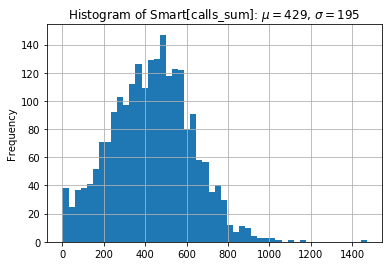

In [104]:
smart['calls_sum'].plot(
    kind='hist', bins=50, grid=True, title='Histogram of Smart[calls_sum]: $\mu=429$, $\sigma=195$')
plt.show()

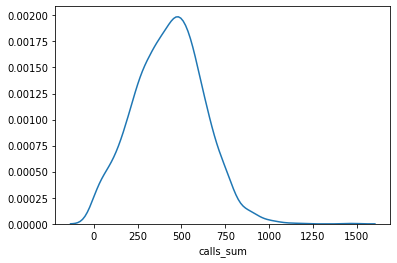

In [105]:
sns.distplot(smart['calls_sum'], hist=False)
plt.show()

#### Описание распределения

Распределение непрерывной величины - количества потраченных минут разговора, так же близко к нормальному распределению. Но оно имеет большу ассиметричность, с более выраженной скошенностью влево.

#### Исследование параметра 'mess_count'

In [106]:
smart['mess_count'].mean()

33.384028712427096

In [107]:
smart_var_mess = np.var(smart['mess_count'], ddof=1)

In [108]:
smart_var_mess

796.8129584480083

In [109]:
smart_st_d_mess = np.std(smart['mess_count'], ddof=1)

In [110]:
smart_st_d_mess

28.22787555676141

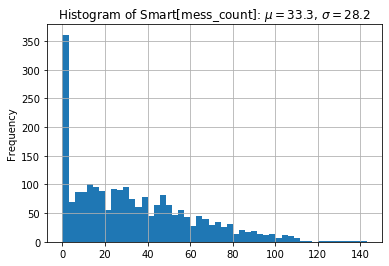

In [111]:
smart['mess_count'].plot(
    kind='hist', bins=50, grid=True, title='Histogram of Smart[mess_count]: $\mu=33.3$, $\sigma=28.2$')
plt.show()

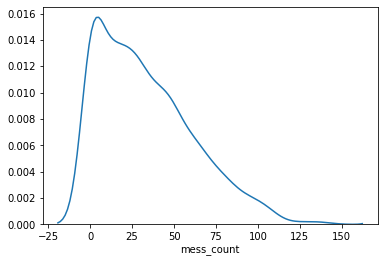

In [112]:
sns.distplot(smart['mess_count'], hist=False)
plt.show()

#### Описание распределения

Количество отправленных сообщений - величина дискретная, посчитать ее можно только целыми числами. Распределение этой величины похоже на распределение пуассона и имеет явную скошенность вправо.

### Вывод: тариф "Смарт"

Проанализировав средние размеры использованных услуг и их распределения можно сделать некоторые выводы о поведении клиентов:
- Самый малоактивный месяц у пользователей тарифа "Смарт" - январь, к нему же можно добавить и февраль. В эти месяцы активность пользователей составляет ~50% и ~66% соответственно от средней месячной активности по году. Что в свою очередь означает снижение нагрузки на инфраструктуру компании.
- Во всех месяцах в течение года средний показатель использованных минут разговора ниже порогового значения тарифного плана. Люди совсем изредка переплачивают за эту услугу. 
- То же самое можно сказать и про число отправленных сообщений, в среднем пользователям более чем хватает лимита на отправку сообщений. Максимальный показатель составляет 72% и приходится на самый активный месяц в году - декабрь.
- Больше всего дополнительного дохода компании приносит продажа интернет трафика сверх лимита тарифа. В 8 месяцах из 12 среднее значение фактически использованного интернет трафика больше установленного тарифом лимита. В декабре в среднем люди тратили дополнительных мегабайтов в размере 18% от месячного лимита, что безусловно очень приличный показатель. 

### Тариф "Ультра"

In [113]:
ultra.head()

,user_id,month,mb_used,calls_count,calls_sum,mess_count,tariff,city,tariff_fee,city_category,add_int_gb,add_int_cost,add_calls_min,add_calls_cost,add_mess_count,add_mess_cost,revenue
0,1000,5.0,2257.0,22.0,164.0,22.0,ultra,краснодар,1950,другой,0.0,0.0,0.0,0.0,0.0,0.0,1950.0
1,1000,6.0,23262.0,43.0,187.0,60.0,ultra,краснодар,1950,другой,0.0,0.0,0.0,0.0,0.0,0.0,1950.0
2,1000,7.0,14017.0,47.0,346.0,75.0,ultra,краснодар,1950,другой,0.0,0.0,0.0,0.0,0.0,0.0,1950.0
3,1000,8.0,14072.0,52.0,418.0,81.0,ultra,краснодар,1950,другой,0.0,0.0,0.0,0.0,0.0,0.0,1950.0
4,1000,9.0,14583.0,58.0,478.0,57.0,ultra,краснодар,1950,другой,0.0,0.0,0.0,0.0,0.0,0.0,1950.0


In [114]:
ultra_general = (ultra
               .pivot_table(index='month', 
                            values=('mb_used','calls_sum','mess_count'), 
                            aggfunc=('mean'))
               .reset_index()
             )

In [115]:
ultra_general

,month,calls_sum,mb_used,mess_count
0,1.0,440.888889,13154.666667,33.777778
1,2.0,304.666667,11788.333333,21.958333
2,3.0,503.081081,17553.513514,32.297297
3,4.0,470.072727,16845.254545,31.563636
4,5.0,524.865672,19383.194030,37.850746
5,6.0,492.428571,18943.928571,41.726190
6,7.0,560.296703,20516.571429,49.846154
7,8.0,524.570093,19595.878505,48.439252
8,9.0,553.643478,19224.043478,52.286957
9,10.0,572.829268,20065.536585,58.430894


#### Исследование параметра 'mb_used'

In [116]:
ultra['mb_used'].mean()

19488.703553299492

In [117]:
ultra_var_int = np.var(ultra['mb_used'], ddof=1)

In [118]:
ultra_var_int

101951580.6864203

In [119]:
ultra_st_d_int = np.std(ultra['mb_used'], ddof=1)

In [120]:
ultra_st_d_int

10097.107540598956

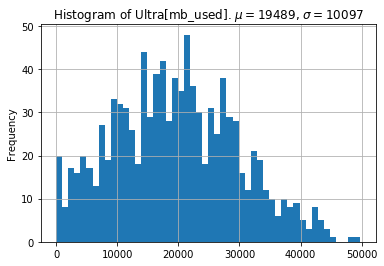

In [121]:
ultra['mb_used'].plot(
    kind='hist', bins=50, grid=True, title='Histogram of Ultra[mb_used]. $\mu=19489$, $\sigma=10097$')
plt.show()

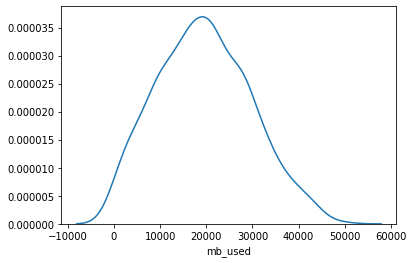

In [122]:
sns.distplot(ultra['mb_used'], hist=False)
plt.show()

#### Описание распределения

Распределение непрерывной величины - количества использованных мегабайтов трафика абонентов тарифа "Ультра", похоже на нормальное распределение. Но так как у пользователей тарифа "Смарт" имеет небольшую скошенность влево.

#### Исследование параметра 'calls_sum'

In [123]:
ultra['calls_sum'].mean()

540.7796954314721

In [124]:
ultra_var_calls = np.var(ultra['calls_sum'], ddof=1)

In [125]:
ultra_var_calls

106105.72682307787

In [126]:
ultra_st_d_calls = np.std(ultra['calls_sum'], ddof=1)

In [127]:
ultra_st_d_calls

325.7387401324532

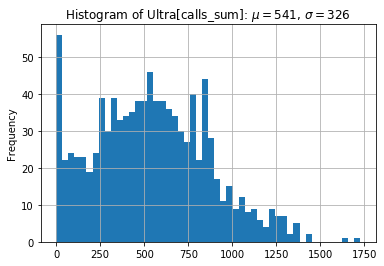

In [128]:
ultra['calls_sum'].plot(
    kind='hist', bins=50, grid=True, title='Histogram of Ultra[calls_sum]: $\mu=541$, $\sigma=326$')
plt.show()

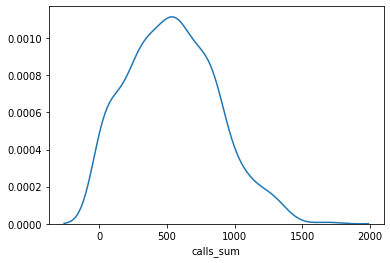

In [129]:
sns.distplot(ultra['calls_sum'], hist=False)
plt.show()

#### Описание распределения

Распределение значений параметра 'calls_sum' имеет явную скошенность влево.

#### Исследование параметра 'mess_count'

In [130]:
ultra['mess_count'].mean()

49.36345177664975

In [131]:
ultra_var_mess = np.var(ultra['mess_count'], ddof=1)

In [132]:
ultra_var_mess

2285.266142544674

In [133]:
ultra_st_d_mess = np.std(ultra['mess_count'], ddof=1)

In [134]:
ultra_st_d_mess

47.80445735017472

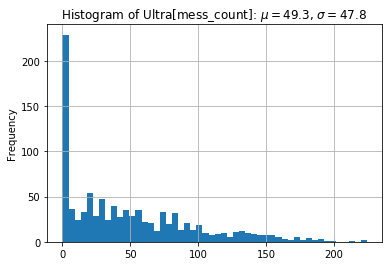

In [135]:
ultra['mess_count'].plot(
    kind='hist', bins=50, grid=True, title='Histogram of Ultra[mess_count]: $\mu=49.3$, $\sigma=47.8$')
plt.show()

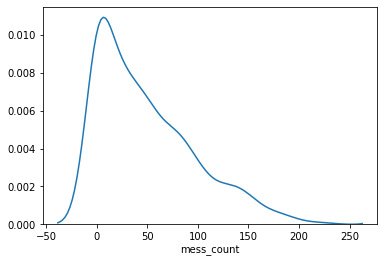

In [136]:
sns.distplot(ultra['mess_count'], hist=False)
plt.show()

#### Описание распределения

Распределению величины 'mess_count' в тарифе Ультра похоже на распределение Пуассона и имеет сильную скошенность вправо.

### Вывод: тариф "Ультра"

При анализ тарифа "Ультра" так же можно найти интересные закономерности: 
- Первое что бросается в глаза, это тот факт что самый малоактивный месяц здесь февраль, а не январь как у пользователей тарифа "Смарт". Здесь было бы интересно проанализировать профессии людей, узнать почему пользователи с этим тарифом ведут более активную жизнь в месяц с самым большим количеством выходных дней. Но в феврале заметен явный спад. То есть январь - работают, февраль - идут в отпуск. Может "Ультра" - корпоративный тариф? или его часто выбирают себе люди определенных профессий? В общем было бы интересно детальнее изучить этот факт.
- В среднем пользователи тарифа "Ультра" больше разговаривают по телефону чем пользователи тарифа "Смарт". Но это значение больше на ~20% а не на 500% как предполагается тарифом. Значение в 3000 бесплатных предусмотренных минут кажется слабообоснованным. На мой взгляд в такой ситуации (лимите в 3000, а максимуме в 500-600) это может означать достижение потенциального максимума количества необходимых человеку разговоров, как рабочих так и личных. Пользователи максимум расходуют 20% от бесплатного лимита!
- Аналогична ситуация и с сообщениями. У этой услуги кажется тоже найден потенциальный максимум. В новогодний месяц отправляют в среднем 60 сообщений. Это 6% от лимита. Похоже в эпоху мессенджеров спрос на сообщения скоро вообще исчезнет. 
- С использованием интернет-трафика ситуация похожая. Значение среднего количества использованных гигабайтов трафика колеблется около 20. В новогодний месяц ~22 или 73% от лимита. Похоже и для пребывания в интернете найден человеческий предел:)

    Подводя итог можно сказать что значения лимитов в тарифе "Ультра" явно завышены и не отвечают требованиям рынка. Сделано это преднамеренно или нет остается гадать британским ученым.

## Постановка и проверка гипотез <a id="hypotesis_and_ab_testing"></a>

### Гипотеза №1: средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.

Нулевая гипотеза формулируется следующим образом: средняя выручка абонентов тарифа "Смарт" равна средней выручке тарифа "Ультра" (наблюдаемые различия случайны).

Альтернативная гипотеза: средняя выручка абонентов тарифа "Смарт" отличается от средней выручки тарифа "Ультра".

Задача теста - опровергнуть нулевую гипотезу.

alpha = 0.05 (5%) - допустимая вероятность случайно обнаружить опровержение нулевой гипотезы.

In [137]:
smart['revenue'].mean()

709.192462987887

In [138]:
ultra['revenue'].mean()

1950.0

In [139]:
np.var(smart['revenue'])

78185.64398087852

In [140]:
np.var(ultra['revenue'])

0.0

In [141]:
results = st.ttest_ind(smart['revenue'], ultra['revenue'], equal_var=False)

In [142]:
alpha = .05

In [143]:
print('p-value =',results.pvalue)

p-value = 0.0


In [144]:
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Отвергаем нулевую гипотезу


### Вывод

Значение p-value это вероятность случайно опровергнуть нулевую гипотезу (средние выручки равны). По результатам эксперимента видно что вероятность получить такой результат случайно меньше статистически значимой величины. Значит мы отвергаем нулевую гипотезу о равенстве средних двух выборок.

Вывод: средняя выручка абонентов тарифа "Смарт" отличается от средней выручки абонентов тарифа "Ультра".

Результат эксперимента подтверждается [сторонним тестом](https://www.evanmiller.org/ab-testing/t-test.html#!1312.512337/830.751708/2229;2071.06599/378.610042/985@95).

### Гипотеза №2: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Нулевая гипотеза формулируется следующим образом: средняя выручка абонентов из Москвы равна средней выручке абонентов из других городов.

Альтернативная гипотеза: средняя выручка абонентов из Москвы отличается от средней выручки из других регионов.

Задача теста - опровергнуть нулевую гипотезу.

alpha = 0.05 (5%) - допустимая вероятность случайно обнаружить опровержение нулевой гипотезы.

In [145]:
all = pd.concat([smart, ultra])

In [146]:
moscow = all.query('city_category == "москва"')

In [147]:
another = all.query('city_category == "другой"')

In [148]:
moscow['revenue'].mean()

1157.620294599018

In [149]:
another['revenue'].mean()

1073.4667691125624

In [150]:
np.var(moscow['revenue'])

406622.94256685267

In [151]:
np.var(another['revenue'])

374209.33994449803

In [152]:
results_1 = st.ttest_ind(moscow['revenue'], another['revenue'])

In [153]:
alpha_1 = .05

In [154]:
print('p-value =',results_1.pvalue)

p-value = 0.002429720967251651


In [155]:
if (results_1.pvalue < alpha_1):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Отвергаем нулевую гипотезу


### Вывод

Значение p-value это допустимая вероятность случайно опровергнуть нулевую гипотезу (средние выручки из Москвы и других регионов равны). Вероятность случайно получить такой результат почти 58% - это слишком большое значение. Следовательно в этом эксперименте отвергнуть нулевую гипотезу недопустимо. 

Результат эксперимента подтверждается [сторонним тестом](https://www.evanmiller.org/ab-testing/t-test.html#!1561.220949/752.597865/611;1541.177103/814.377534/2603@95).

## Общий вывод <a id="conclusion"></a>

По результатам исследования были поставлены и проверены 2 гипотезы. 

В результате проведения A/B - тестов по каждой гипотезе можно следать следующие выводы:

- Исходя из предоставленных данных о пользователях, средняя выручка 2 исследуемых тарифов различается. Однако стоит заметить что в представленной выборке из 500 абонентов, отношение пользователей тарифа "Смарт" к пользователям тарифа "Ультра" было 3/1. Отвечая на вопрос коммерческого департамента я могу с уверенностью сказать что тариф "Ультра" приносит больше денег чем тариф "Смарт".

- В ходе проверки 2 гипотезы удалось достоверно установить что средняя выручка от клиентов из Москвы и из других регионов принципиально не отличается. Люди во всех регионах в среднем платят похожую сумму за услуги связи.